# **EE4C12-Epileptic-Seizure-Detection-using-EEG**

## *Classification of EEG signals using Deep Neural Network*


    
Group 16 Members:

    1. Zhixuan Ge  
    2. Yanqi Hong 

## 1. Import Libraries and Load Data

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
random_state = 42
device = "cuda"

In [6]:
#load data on Yanqi Hong's computer
data = pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q1\EE4C12 Machine Learning For Electrical Engineering\CodeLab\Project\S&S_SZD (1)\Data\Project_Data_EE4C12_S&S_SZD.csv')
data

# # load data on Zhixuan's computer
# data = pd.read_csv('D:\\User\Zhixuan Ge\Onedrive TUDelft\OneDrive - Delft University of Technology\Courses\ML for EE\SZD\S&S_SZD\Project_Data_EE4C12_S&S_SZD.csv')
# data

,Patient,annotation,min|FP1-F7,min|F7-T3,min|T3-T5,min|T5-O1,min|FP2-F8,min|F8-T4,min|T4-T6,min|T6-O2,...,norm_power_HF|CZ-C4,norm_power_HF|C4-T4,norm_power_HF|FP1-F3,norm_power_HF|F3-C3,norm_power_HF|C3-P3,norm_power_HF|P3-O1,norm_power_HF|FP2-F4,norm_power_HF|F4-C4,norm_power_HF|C4-P4,norm_power_HF|P4-O2
0,258,1,50,61,57,53,39,35,39,35,...,0.016087,0.066920,0.102402,0.481384,0.690787,0.154544,0.062533,0.046460,0.066575,0.086999
1,258,1,48,62,60,46,38,35,39,33,...,0.024006,0.064857,0.031791,0.225788,0.409987,0.184671,0.071133,0.022369,0.079494,0.047536
2,258,1,51,60,59,45,38,36,40,36,...,0.037326,0.100177,0.050009,0.622584,0.394504,0.225516,0.050673,0.044906,0.102142,0.068105
3,258,1,49,58,56,42,36,36,41,37,...,0.027546,0.107883,0.014017,0.359140,0.276964,0.104977,0.018042,0.079467,0.078255,0.089385
4,258,1,45,57,61,41,35,37,41,37,...,0.036820,0.182520,0.031397,0.328354,0.156929,0.151952,0.047532,0.135071,0.098320,0.137701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55451,11580,-1,75,73,81,80,66,80,77,75,...,0.244334,0.625396,0.023821,0.058277,0.083594,0.114426,0.119654,0.295364,0.185930,0.199585
55452,11580,-1,74,74,77,71,79,75,82,77,...,0.588236,0.743060,0.076294,0.332341,0.228458,0.170603,0.351418,0.638666,0.490806,0.307429
55453,11580,-1,72,76,72,73,74,76,80,76,...,0.296041,0.770194,0.041190,0.090919,0.186074,0.216797,0.231053,0.770637,0.285257,0.413382
55454,11580,-1,77,82,74,75,82,85,80,76,...,0.440360,0.720855,0.026959,0.026340,0.077674,0.269610,0.186769,0.790173,0.473615,0.415771


## 2. Data Preprocessing

In [7]:
# train test split

X = data.iloc[:, 2:].values
y = np.int32(data['annotation'].values)

test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [8]:
# standardize data

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

The original number of training feature is:  360


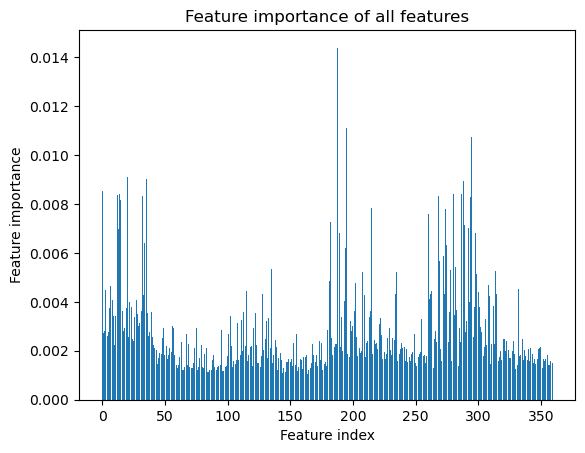

The current number of training feature after feature selection is:  120


In [9]:
# Feature selection by extra tree classifier

print("The original number of training feature is: ", X_train_scaled.shape[1])
clf_etc = ExtraTreesClassifier(random_state=random_state).fit(X_train_scaled, y_train) # fit the model
feature_importances = clf_etc.feature_importances_  # get the feature importance

plt.bar(range(len(feature_importances)), feature_importances)   # plot the feature importance
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of all features")
plt.show()

important_feature_indices=np.argsort(feature_importances)   # sort the feature importance  
important_feature_indices_cut=important_feature_indices[:int(len(important_feature_indices)/1.5)]   # select the most important features  

X_train_selected=np.delete(X_train_scaled,important_feature_indices_cut,1)    # delete the least important features
X_test_selected=np.delete(X_test_scaled,important_feature_indices_cut,1)      # delete the least important features
print("The current number of training feature after feature selection is: ", X_train_selected.shape[1])

In [11]:
# Feature selection by PCA

pca = PCA().fit(X_train_scaled)

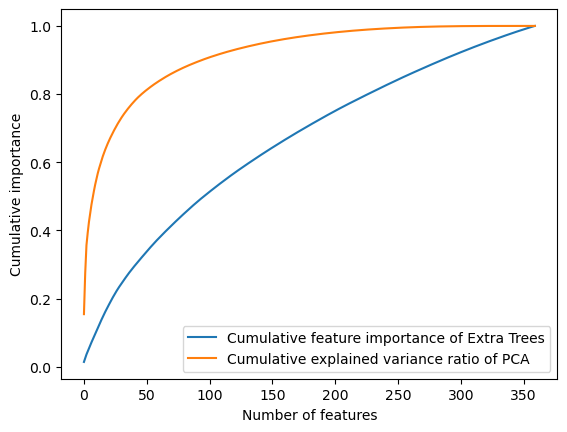

In [12]:
# Plot the cumulative explained variance ratio for PCA and cumulative feature importance for Extra Trees

plt.plot(np.sort(feature_importances)[::-1].cumsum(), label='Cumulative feature importance of Extra Trees')
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Cumulative explained variance ratio of PCA')
plt.xlabel('Number of features')
plt.ylabel('Cumulative importance')
plt.legend()

In [ ]:
#############################################################################################################
# Attempt：oversample and undersample

# The oversample and undersample method can increase the discrimination of the samples with label 0
# However, the oversample and undersample method is not used in the final model because it will decrease the accuracy of the model, so that the model cannot predict the label 1 and -1 correctly
#############################################################################################################


# num_zero=np.sum(y_train==0)
# num_one=np.sum(y_train==1)
# num_negatives_one=np.sum(y_train==-1)
# print('The original sample number of 0 is', num_zero)
# print('The original sample number of 1 is', num_one)
# print('The original sample number of -1 is', num_negatives_one)

# # oversampling & undersampling
# smt = SMOTETomek(random_state=Shuffle_state)
# X_train_selected, y_train = smt.fit_resample(X_train_selected, y_train)

# num_zero=np.sum(y_train==0)
# num_one=np.sum(y_train==1)
# num_negatives_one=np.sum(y_train==-1)

# print('')
# print('The current sample number of 0 is', num_zero)
# print('The current sample number of 1 is', num_one)
# print('The current sample number of -1 is', num_negatives_one)

## 3. Model Training

### 3.1 Model construction

In [13]:
# Create data tensor

class Data_tensor(Dataset):
    def __init__(self, X, y):
        X = np.float32(X)
        X = torch.from_numpy(X)
        # In pytorch, labels must start from 0
        # shift required
        y = np.longlong(y) - y.min()
        y = torch.from_numpy(y)
        
        self.X = X.to(device)
        self.y = y.to(device)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
# DNN class for random search
class DNN_rs(nn.Module):
    # Available activation functions: ReLU, Sigmoid, Tanh, LeakyReLU, ELU, SELU, Softplus, Softsign, LogSigmoid, PReLU, Softmin, Softmax, if the input is not in the list, ReLU will be used
    def __init__(self, input_size, hidden_sizes, output_size, activition_layer=nn.ReLU()):
        super(DNN_rs, self).__init__()
        depth=len(hidden_sizes)
        layers = []
        for i in range(depth):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i])) 
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if activition_layer=="ReLU":
                layers.append(nn.ReLU())
            elif activition_layer=="Sigmoid":
                layers.append(nn.Sigmoid())
            elif activition_layer=="Tanh":
                layers.append(nn.Tanh())
            elif activition_layer=="LeakyReLU":
                layers.append(nn.LeakyReLU())
            elif activition_layer=="ELU":
                layers.append(nn.ELU())
            elif activition_layer=="SELU":
                layers.append(nn.SELU())
            elif activition_layer=="Softplus":
                layers.append(nn.Softplus())
            elif activition_layer=="Softsign":
                layers.append(nn.Softsign())
            elif activition_layer=="LogSigmoid":
                layers.append(nn.LogSigmoid())
            elif activition_layer=="PReLU":
                layers.append(nn.PReLU())
            elif activition_layer=="Softmin":
                layers.append(nn.Softmin())
            elif activition_layer=="Softmax":
                layers.append(nn.Softmax())
            else:
                layers.append(nn.ReLU())
        layers.append(nn.Linear( hidden_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [15]:
# Test output for DNN_rs
input_size = X_train_scaled.shape[1]
output_size = 3
model_rs = DNN_rs(input_size, hidden_sizes=[100], output_size=output_size, activition_layer="PReLU")
print(model_rs)

DNN_rs(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=100, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [16]:
# Train and test functions
def train(dataloader, model, loss_fn, optimizer):  
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>5f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-classification
optimizer_rs = torch.optim.Adam(model_rs.parameters(),weight_decay=0.005)   # Adam optimizer for random search

In [18]:
#k fold cross validation function
def Kfold_split(X_train, y_train, Shuffle_state, k=5):   # Split the data into training and validation sets
    #example : X_k_train, y_k_train, X_k_val, y_k_val = Kfold_split(X_train, y_train, Shuffle_state)
    kf = KFold(n_splits=k, random_state=Shuffle_state, shuffle=True)    # 5-fold cross validation
    kf.get_n_splits(X_train)    
    X_k_train = []
    y_k_train = []
    X_k_val = []
    y_k_val = []
    
    for train_index, val_index in kf.split(X_train):  # Split the data into training and validation sets
        X_k_train.append(X_train[train_index])
        y_k_train.append(y_train[train_index])
        X_k_val.append(X_train[val_index])
        y_k_val.append(y_train[val_index])
    
    return X_k_train, y_k_train, X_k_val, y_k_val

In [19]:
# Generate the performance value and confusion matrix 

def performance_eval(true, pred, score_display=True, matrix_display=False, result_return=False):
    Accuracy = accuracy_score(true, pred)
    F1 = accuracy_score(true, pred)
    Precision = accuracy_score(true, pred)
    Recall = accuracy_score(true, pred)
    
    if score_display==True:
        print("Accuracy: " + str(Accuracy))
        print("F1 score: " + str(F1))
        print("Recall score: " + str(Recall))
        print("Precision score: " + str(Precision))
        
    if matrix_display==True:
        label = ['Non-seizure', 'Transition','Seizure']
        cm = confusion_matrix(true, pred)
        cm_display = ConfusionMatrixDisplay(cm, display_labels=label).plot()
        plt.show(cm_display)
    
    if result_return:
        return Accuracy, F1, Precision, Recall

### 3.2 Model training

In [20]:
# Create train and validation dataloader
batch_size = 1024

train_dataloader_list = []
val_dataloader_list = []

X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_selected, y_train, random_state)   # K-fold cross validation for DNN
for i in range(5):
    trainset_gpu = Data_tensor(X_k_train_list[i], y_k_train_list[i])
    valset_gpu = Data_tensor(X_k_val_list[i], y_k_val_list[i])
    train_dataloader_list.append(DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True))
    val_dataloader_list.append(DataLoader(valset_gpu, batch_size=batch_size, shuffle=True))
    
valset_gpu_k = Data_tensor(X_train_selected, y_train)
val_dataloader_k = DataLoader(valset_gpu_k, batch_size=batch_size, shuffle=True)
testset_gpu = Data_tensor(X_test_selected, y_test)
test_dataloader = DataLoader(testset_gpu, batch_size=batch_size, shuffle=False)

In [21]:
# Define the hyper parameters for random search

min_width=8  # The minimum number of neurons in each hidden layer
max_width=512   # The maximum number of neurons in each hidden layer
min_hl=1    # The minimum number of hidden layers
max_hl=3    # The maximum number of hidden layers
activition_list = ["ReLU", "Tanh", "LeakyReLU","Sigmoid"]   # The activation function list

optimizer_list = ["SGD", "Adam"]    
min_learning_rate=0.0001
max_learning_rate=0.5

def get_hps():
    num_hl = random.randint(min_hl, max_hl)
    hl = []
    for i in range(num_hl):
        hl.append(random.randint(min_width, max_width))
    alpha = np.power(10, random.uniform(-4, 0))  # The L2 rate is in the range of 10^-4 to 10^0
    activition = random.choice(activition_list)
    optimizer = random.choice(optimizer_list)
    lr = random.uniform(min_learning_rate, max_learning_rate)
    
    return {'hl': hl, 'alpha': alpha, 'activition': activition, 'optimizer': optimizer, 'lr': lr}
    

In [22]:
# Random search on cross validation set

random.seed(random_state)

input_size=X_test_selected.shape[-1]
output_size=3
epochs = 20
num_search = 10

accuracy_list = []
hp_list = []
pm_list = []

for search in range(num_search):
    print('-'*20)
    hp = get_hps()
    print(hp)
    model_rs = DNN_rs(input_size=input_size, hidden_sizes=hp['hl'], output_size=output_size, activition_layer=hp['activition']).to(device)
    
    if hp['optimizer'] == 'SGD':
        optimizer_rs = torch.optim.SGD(model_rs.parameters(), lr=hp['lr'], weight_decay=hp['alpha'])
    elif hp['optimizer'] == 'Adam':
        optimizer_rs = torch.optim.Adam(model_rs.parameters(), lr=hp['lr'], weight_decay=hp['alpha'])
    else:
        print("Error")
        break
        
    loss_fn = nn.CrossEntropyLoss()

    for i in range(epochs):
        train_dataloader = train_dataloader_list[i%5]
        validation_dataloader = val_dataloader_list[i%5]
        model_rs.train()
        train(train_dataloader, model_rs, loss_fn, optimizer_rs)
        test(validation_dataloader, model_rs, loss_fn)
        
        if (i+1)%5==0:
            model_rs.eval()
            pred = model_rs(val_dataloader_k.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
            true = val_dataloader_k.dataset[:][1].cpu().numpy()
            accuracy_list.append(accuracy_score(true, pred))
            hp.update({'epoch': i+1})
            hp_list.append(hp.copy())
            pm_list.append(model_rs.state_dict())
    print('-'*20)
    
accuracy_list = np.array(accuracy_list)

--------------------
{'hl': [65, 20, 387], 'alpha': 0.0012592654080437007, 'activition': 'Tanh', 'optimizer': 'SGD', 'lr': 0.3682619599605898}
loss: 1.146729  [ 1024/33273]
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.498865 

loss: 0.537398  [ 1024/33273]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.444973 

loss: 0.420851  [ 1024/33274]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.452886 

loss: 0.472352  [ 1024/33274]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.413618 

loss: 0.393033  [ 1024/33274]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.428023 

loss: 0.440734  [ 1024/33273]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.392747 

loss: 0.388521  [ 1024/33273]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.393297 

loss: 0.402322  [ 1024/33274]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.365409 

loss: 0.360479  [ 1024/33274]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.376193 

loss: 0.386192  [ 1024/33274]
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.356951 

loss: 0.362530  [ 1024/33273]
Test Er

--------------------
The best accuracy in validation set is:  0.8877187920753992
The best hyperparameter is:  {'hl': [346], 'alpha': 0.0008158176606636853, 'activition': 'LeakyReLU', 'optimizer': 'SGD', 'lr': 0.4276733287354719, 'epoch': 20}
--------------------
Accuracy: 0.8744229659549914
F1 score: 0.8744229659549914
Recall score: 0.8744229659549914
Precision score: 0.8744229659549914


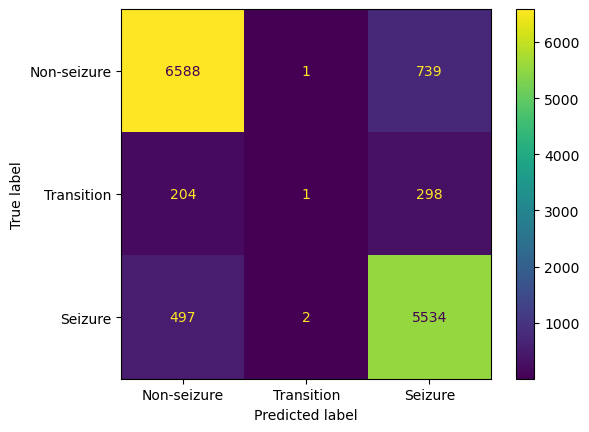

In [23]:
# Find the best hyper parameters and show the performance on test set

best_idx = np.argmax(accuracy_list)
hp = hp_list[best_idx]
print("-"*20)
print("The best accuracy in validation set is: ", accuracy_list[best_idx])
print("The best hyperparameter is: ", hp)
print("-"*20)
model_best = DNN_rs(input_size=input_size, hidden_sizes=hp['hl'], output_size=output_size, activition_layer=hp['activition']).to(device)
model_best.load_state_dict(pm_list[best_idx])

model_best.eval()
pred = model_best(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
true = test_dataloader.dataset[:][1].cpu().numpy()

performance_eval(true, pred, matrix_display=True)